In [1]:
### Discriminator
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1,  bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):

    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size = 4,
                stride = 2,
                padding = 1,
                padding_mode="reflect"
            ),
            nn.LeakyReLU(0.2),
            
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride = 1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)



    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [2]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, 
                      kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

Saved output to horse_zebra\output_zebra_1.png
Saved comparison plot to comparison_plot.png


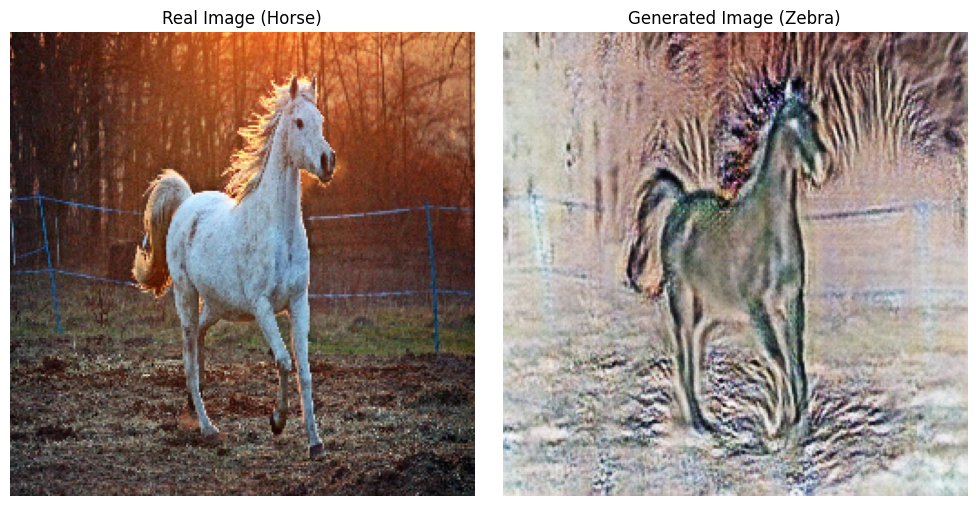

In [17]:
import torch
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "genz.pth.tar"
INPUT_IMAGE_PATH = "horse_infer\horse_1.jpg"
OUTPUT_IMAGE_PATH = "horse_zebra\output_zebra_1.png"
IMG_SIZE = 256

transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255),
    ToTensorV2(),
])

def load_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    transformed = transform(image=image)
    return transformed["image"].unsqueeze(0)  # Add batch dimension

def load_generator(checkpoint_path, img_channels=3):
    model = Generator(img_channels=img_channels).to(DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

def inference(input_path, output_path, checkpoint_path):
    img = load_image(input_path).to(DEVICE)
    
    model = load_generator(checkpoint_path)
    
    with torch.no_grad():
        fake = model(img)
        fake = fake * 0.5 + 0.5 
    
    save_image(fake, output_path)
    print(f"Saved output to {output_path}")
    
    real_img = img * 0.5 + 0.5  
    real_img = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    fake_img = fake.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title("Real Image (Horse)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(fake_img)
    plt.title("Generated Image (Zebra)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('comparison_plot.png') 
    print(f"Saved comparison plot to comparison_plot.png")
    plt.show()  
    plt.close()  

inference(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH, CHECKPOINT_PATH)

Saved output to horse_zebra\output_zebra_2.png
Saved comparison plot to comparison_plot.png


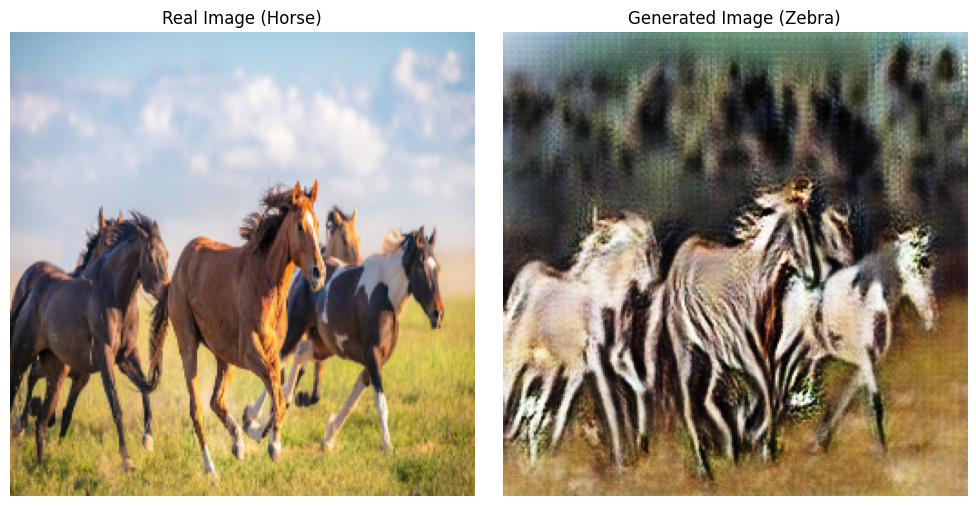

In [13]:
import torch
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "genz.pth.tar"
INPUT_IMAGE_PATH = "horse_infer\horse_3.jpg"
OUTPUT_IMAGE_PATH = "horse_zebra\output_zebra_2.png"
IMG_SIZE = 256

transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255),
    ToTensorV2(),
])

def load_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    transformed = transform(image=image)
    return transformed["image"].unsqueeze(0)  # Add batch dimension

def load_generator(checkpoint_path, img_channels=3):
    model = Generator(img_channels=img_channels).to(DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

def inference(input_path, output_path, checkpoint_path):
    img = load_image(input_path).to(DEVICE)
    
    model = load_generator(checkpoint_path)
    
    with torch.no_grad():
        fake = model(img)
        fake = fake * 0.5 + 0.5 
    
    save_image(fake, output_path)
    print(f"Saved output to {output_path}")
    
    real_img = img * 0.5 + 0.5  
    real_img = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    fake_img = fake.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title("Real Image (Horse)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(fake_img)
    plt.title("Generated Image (Zebra)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('comparison_plot.png') 
    print(f"Saved comparison plot to comparison_plot.png")
    plt.show()  
    plt.close()  

inference(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH, CHECKPOINT_PATH)

### Zebra to horse

Saved output to zebra_horse\output_horse_1.png
Saved comparison plot to comparison_plot.png


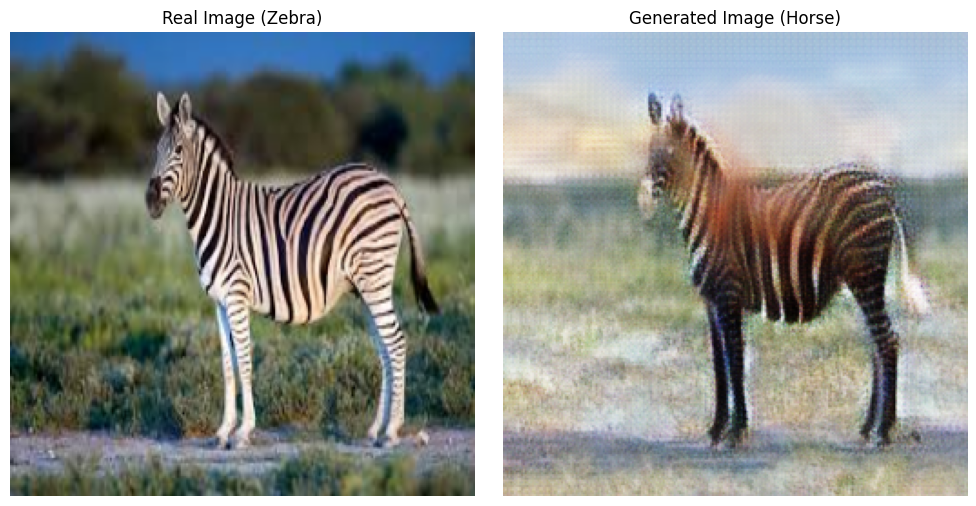

In [15]:
import torch
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "genh.pth.tar"
INPUT_IMAGE_PATH = "zeb_infer\images.jpeg"
OUTPUT_IMAGE_PATH = "zebra_horse\output_horse_1.png"
IMG_SIZE = 256

transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255),
    ToTensorV2(),
])

def load_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    transformed = transform(image=image)
    return transformed["image"].unsqueeze(0)  # Add batch dimension

def load_generator(checkpoint_path, img_channels=3):
    model = Generator(img_channels=img_channels).to(DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

def inference(input_path, output_path, checkpoint_path):
    img = load_image(input_path).to(DEVICE)
    
    model = load_generator(checkpoint_path)
    
    with torch.no_grad():
        fake = model(img)
        fake = fake * 0.5 + 0.5 
    
    save_image(fake, output_path)
    print(f"Saved output to {output_path}")
    
    real_img = img * 0.5 + 0.5  
    real_img = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    fake_img = fake.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title("Real Image (Zebra)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(fake_img)
    plt.title("Generated Image (Horse)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('comparison_plot.png') 
    print(f"Saved comparison plot to comparison_plot.png")
    plt.show()  
    plt.close()  

inference(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH, CHECKPOINT_PATH)

Saved output to zebra_horse\output_horse_2.png
Saved comparison plot to comparison_plot.png


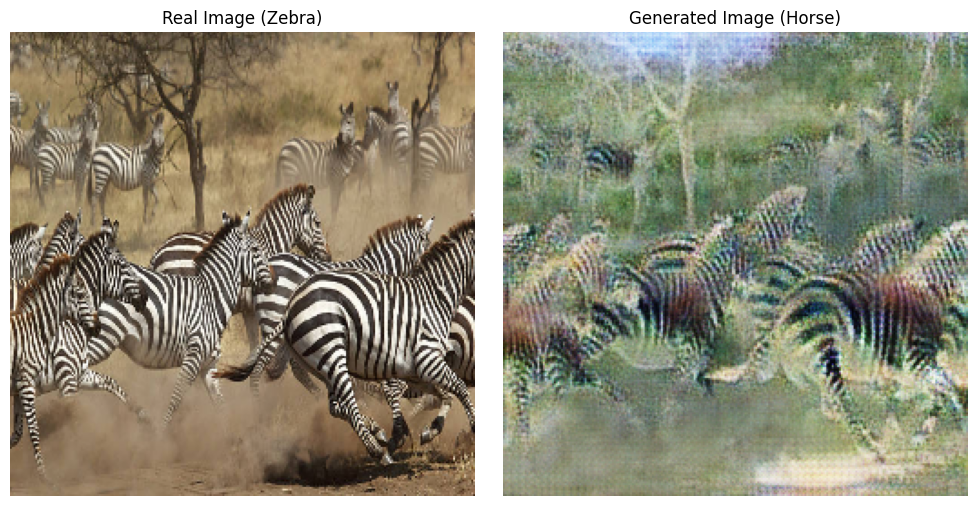

In [16]:
import torch
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "genh.pth.tar"
INPUT_IMAGE_PATH = "zeb_infer\zeb_2.jpg"
OUTPUT_IMAGE_PATH = "zebra_horse\output_horse_2.png"
IMG_SIZE = 256

transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255),
    ToTensorV2(),
])

def load_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    transformed = transform(image=image)
    return transformed["image"].unsqueeze(0)  # Add batch dimension

def load_generator(checkpoint_path, img_channels=3):
    model = Generator(img_channels=img_channels).to(DEVICE)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

def inference(input_path, output_path, checkpoint_path):
    img = load_image(input_path).to(DEVICE)
    
    model = load_generator(checkpoint_path)
    
    with torch.no_grad():
        fake = model(img)
        fake = fake * 0.5 + 0.5 
    
    save_image(fake, output_path)
    print(f"Saved output to {output_path}")
    
    real_img = img * 0.5 + 0.5  
    real_img = real_img.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    fake_img = fake.squeeze(0).permute(1, 2, 0).cpu().numpy() 
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title("Real Image (Zebra)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(fake_img)
    plt.title("Generated Image (Horse)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('comparison_plot.png') 
    print(f"Saved comparison plot to comparison_plot.png")
    plt.show()  
    plt.close()  

inference(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH, CHECKPOINT_PATH)